In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\notebooks


In [2]:
import sys
from pathlib import Path

print("Current working directory:", Path.cwd())

# Try both possibilities robustly
cwd = Path.cwd()

if (cwd / "src").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "src").exists():
    PROJECT_ROOT = cwd.parent
else:
    raise RuntimeError("Cannot find project root containing 'src' folder")

sys.path.insert(0, str(PROJECT_ROOT))

print("Resolved project root:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])
print("Contents of project root:", [p.name for p in PROJECT_ROOT.iterdir()])


Current working directory: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\notebooks
Resolved project root: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
sys.path[0]: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
Contents of project root: ['data', 'experiments', 'figures', 'notebooks', 'reports', 'src']


In [3]:
from src.utils import load_dataset
from src.datasets import encode_target, select_base_features
from src.features import add_irregularity_index

print("Imports successful")


Imports successful


In [4]:
from src.utils import load_dataset
from src.datasets import encode_target, select_base_features
from src.features import add_irregularity_index

df = load_dataset("data/breast_cancer_wisconsin.csv")
df = encode_target(df)
df = select_base_features(df)
df_feat = add_irregularity_index(df)

df_feat.head()


,concavity_mean,perimeter_mean,radius_mean,area_mean,target,irregularity_index
0,0.3001,122.80,17.99,1001.0,1,0.000020
1,0.0869,132.90,20.57,1326.0,1,0.000005
2,0.1974,130.00,19.69,1203.0,1,0.000012
3,0.2414,77.58,11.42,386.1,1,0.000040
4,0.1980,135.10,20.29,1297.0,1,0.000011


In [5]:
from collections import Counter

class_counts = Counter(df_feat["target"])
total = sum(class_counts.values())

print("Class distribution:")
for cls, count in class_counts.items():
    label = "Malignant" if cls == 1 else "Benign"
    print(f"{label}: {count} ({count/total:.2%})")


Class distribution:
Malignant: 212 (37.26%)
Benign: 357 (62.74%)


In [6]:
from sklearn.model_selection import train_test_split
from src.models import get_logistic_model

# Features and target
X = df_feat[
    [
        "concavity_mean",
        "perimeter_mean",
        "radius_mean",
        "area_mean",
        "irregularity_index",
    ]
]
y = df_feat["target"]

# Stratified split (important under imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Baseline logistic regression
model_base = get_logistic_model()
model_base.fit(X_train, y_train)

y_pred_base = model_base.predict(X_test)
y_prob_base = model_base.predict_proba(X_test)[:, 1]


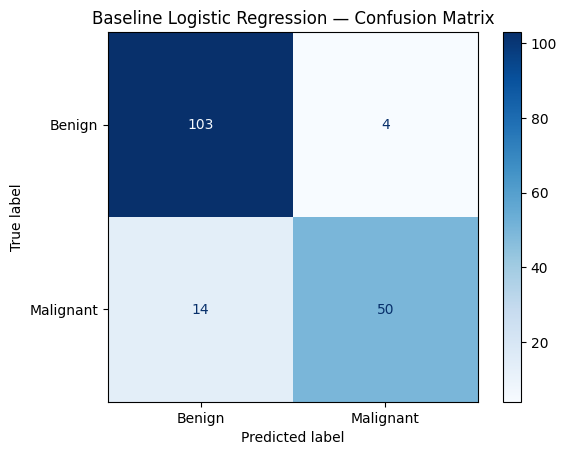

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# Create figures directory if it doesn't exist
fig_dir = Path(PROJECT_ROOT) / "figures"
fig_dir.mkdir(exist_ok=True)

cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Benign", "Malignant"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Baseline Logistic Regression — Confusion Matrix")

# Save figure
plt.savefig(FIGURES_DIR / "h2_confusion_matrix_baseline.png", dpi=300)
plt.savefig(fig_dir / "h2_confusion_matrix_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


In [8]:
from src.models import get_logistic_model


In [9]:
model_weighted = get_logistic_model(class_weight="balanced")
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)


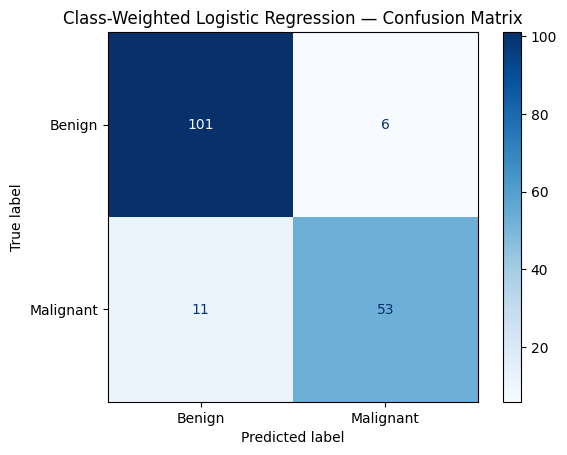

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# Class-weighted logistic regression
model_weighted = get_logistic_model(class_weight="balanced")
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)

# Confusion matrix
cm_w = confusion_matrix(y_test, y_pred_weighted)
disp_w = ConfusionMatrixDisplay(
    confusion_matrix=cm_w,
    display_labels=["Benign", "Malignant"]
)

disp_w.plot(cmap="Blues", values_format="d")
plt.title("Class-Weighted Logistic Regression — Confusion Matrix")

# Save figure
plt.savefig(FIGURES_DIR / "h2_confusion_matrix_weighted.png", dpi=300)

plt.savefig(
    fig_dir / "h2_confusion_matrix_weighted.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


In [11]:
from pathlib import Path

FIGURES_DIR = Path("../figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Figures directory:", FIGURES_DIR.resolve())


Figures directory: C:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\figures


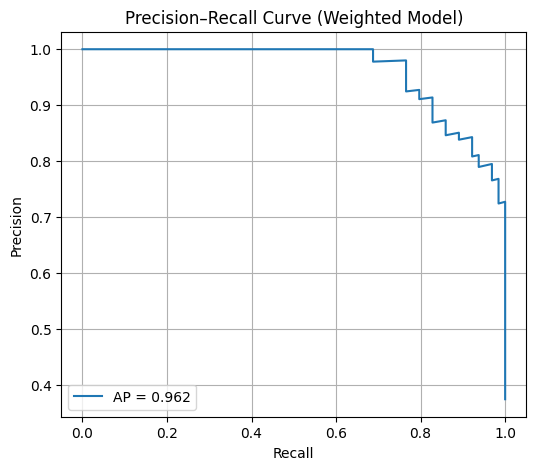

In [17]:
from pathlib import Path
Path("figures").mkdir(exist_ok=True)
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


y_scores = model_weighted.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Weighted Model)")
plt.legend()
plt.grid(True)
plt.savefig(FIGURES_DIR / "h2_precision_recall_curve.png", dpi=300)
plt.show()


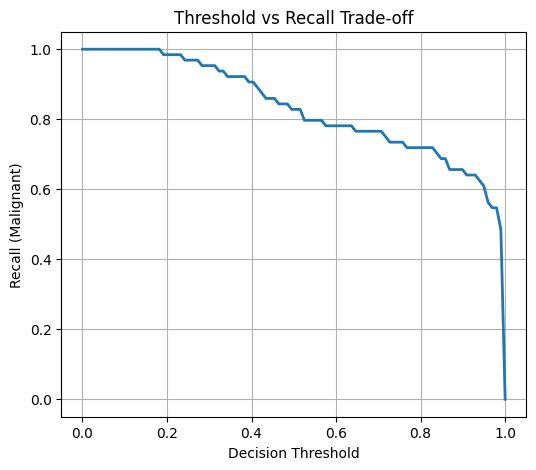

In [13]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 1, 100)
recalls = []

for t in thresholds:
    y_pred_thresh = (y_scores >= t).astype(int)
    
    tp = ((y_test == 1) & (y_pred_thresh == 1)).sum()
    fn = ((y_test == 1) & (y_pred_thresh == 0)).sum()
    
    recall_t = tp / (tp + fn) if (tp + fn) > 0 else 0
    recalls.append(recall_t)

plt.figure(figsize=(6, 5))
plt.plot(thresholds, recalls, linewidth=2)
plt.xlabel("Decision Threshold")
plt.ylabel("Recall (Malignant)")
plt.title("Threshold vs Recall Trade-off")
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h2_threshold_vs_recall.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

